In [1]:
# Import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageOps
from tensorflow.keras import layers

In [19]:
ImgShape = (256, 256)
BatchSize = 1
Epochs = 40

In [4]:
print(len(os.listdir("/content/data/no")))
print(len(os.listdir("/content/data/yes")))

501
501


In [5]:
%rmdir "/content/data/.ipynb_checkpoints"    #Remove checkpoints

In [20]:
#This way tensorflow will automatically load the data
data = tf.keras.utils.image_dataset_from_directory("/content/data", validation_split=0.1, subset='training', seed=83506514,
                                                   image_size=ImgShape, batch_size=BatchSize, label_mode='binary')
TestData = tf.keras.utils.image_dataset_from_directory("/content/data", validation_split=0.1, subset='validation', seed=83506514,
                                                   image_size=ImgShape, batch_size=BatchSize, label_mode='binary')

Found 1002 files belonging to 2 classes.
Using 902 files for training.
Found 1002 files belonging to 2 classes.
Using 100 files for validation.


In [7]:
r = layers.Rescaling(1./255)
f = layers.RandomFlip()
c = layers.RandomContrast(0.2)
t = layers.RandomTranslation(0.05, 0.05)
z = layers.RandomZoom(0.05, 0.05)
ro = layers.RandomRotation(0.1)
def Augment(x, y):
  x = tf.image.rgb_to_grayscale(x)    #Convert to greyscale
  x = f(x)    #Randomly flip the image
  x = r(x)    #Convert to range of 0 to 1


  #Don't change y because that's the label
  return (x, y)

In [8]:
def Grayscale(x, y):
  x = tf.image.rgb_to_grayscale(x)    #Convert to greyscale
  x = r(x)    #This was probably the problem. They were in the wrong range

  return (x, y)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

data = data.cache().shuffle(10000).prefetch(buffer_size=AUTOTUNE)
TestData = TestData.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
data = data.map(Augment)
TestData = TestData.map(Grayscale)

In [11]:
def ConvStep(x, filters, shape, strides=(1, 1), applyBN=True):
  x2 = layers.Conv2D(filters, shape, strides=strides, padding='same')(x)
  if applyBN:
    x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)
  return x2

In [12]:
def MakeModel():    #Using the functional API because I like it better
  inp = layers.Input(shape=(ImgShape[0], ImgShape[1], 1))
  x = ConvStep(inp, 16, (3, 3))
  x = ConvStep(x, 32, (3, 3), strides=(2, 2))
  x = ConvStep(x, 32, (3, 3))
  x = ConvStep(x, 32, (3, 3))
  x = ConvStep(x, 64, (3, 3), strides=(2, 2))
  x = ConvStep(x, 64, (3, 3))
  x = ConvStep(x, 128, (3, 3), strides=(2, 2))
  x = ConvStep(x, 128, (3, 3))
  x = ConvStep(x, 256, (3, 3), strides=(2, 2))
  x = ConvStep(x, 256, (3, 3))
  x = ConvStep(x, 512, (3, 3), strides=(2, 2))
  x = ConvStep(x, 512, (3, 3))
  
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  return tf.keras.Model(inputs=inp, outputs=x)

In [13]:
def MakeModel():    #Using the functional API because I like it better
  inp = layers.Input(shape=(ImgShape[0], ImgShape[1], 1))
  x = ConvStep(inp, 16, (3, 3))
  x = ConvStep(x, 32, (3, 3), strides=(2, 2))
  x = ConvStep(x, 32, (3, 3))
  x = ConvStep(x, 32, (3, 3))
  x = ConvStep(x, 64, (3, 3), strides=(2, 2))
  x = ConvStep(x, 64, (3, 3))
  x = ConvStep(x, 64, (3, 3))
  x = ConvStep(x, 128, (3, 3), strides=(2, 2))
  x = ConvStep(x, 128, (3, 3))
  x = ConvStep(x, 128, (3, 3))
  x = ConvStep(x, 256, (3, 3), strides=(2, 2))
  x = ConvStep(x, 256, (3, 3))
  x = ConvStep(x, 512, (3, 3), strides=(2, 2))
  x = ConvStep(x, 512, (3, 3))
  
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  return tf.keras.Model(inputs=inp, outputs=x)

In [21]:
model = MakeModel()

In [22]:
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

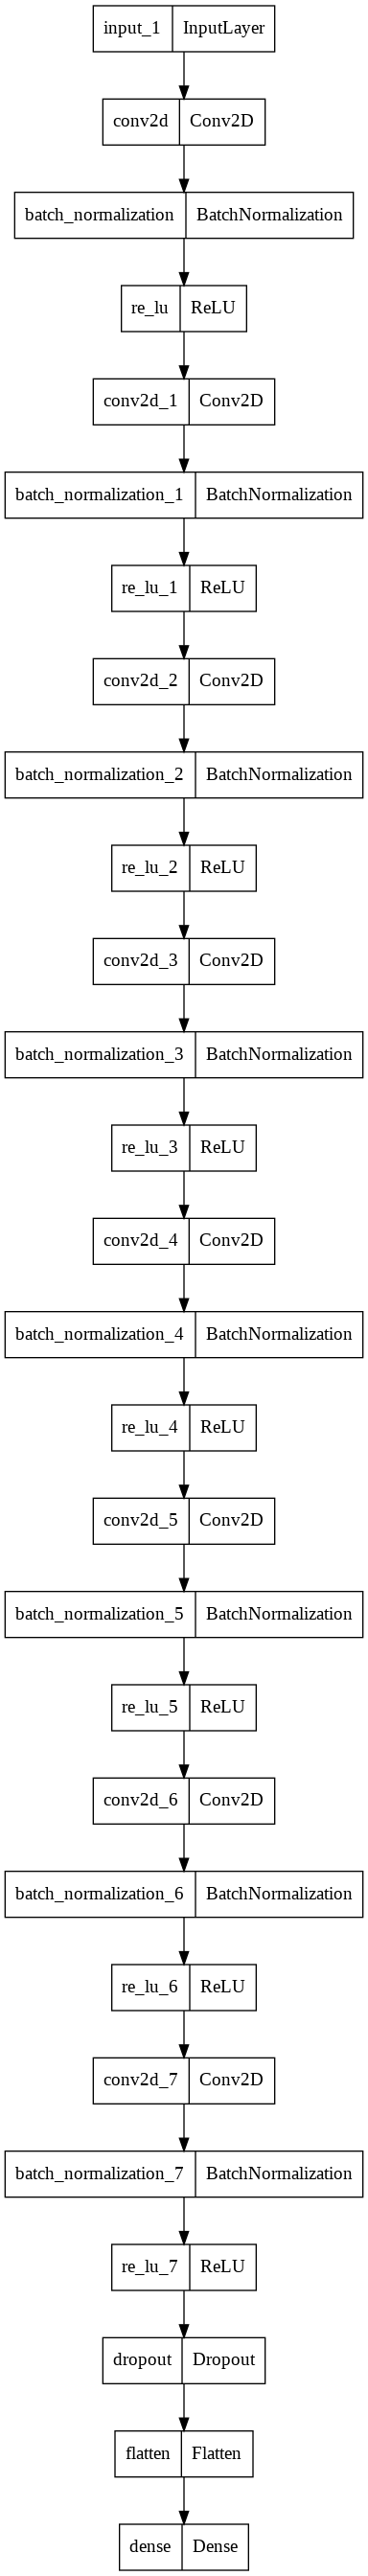

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 batch_normalization_94 (Bat  (None, 256, 256, 16)     64        
 chNormalization)                                                
                                                                 
 re_lu_94 (ReLU)             (None, 256, 256, 16)      0         
                                                                 
 conv2d_95 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_95 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                          

In [ ]:
model.fit(data, validation_data=TestData, batch_size=BatchSize, epochs=10)

Epoch 1/10
169/169 [==============================] - 15s 86ms/step - loss: 0.2098 - accuracy: 0.9507 - val_loss: 0.2778 - val_accuracy: 0.8967
Epoch 2/10
169/169 [==============================] - 15s 87ms/step - loss: 0.2084 - accuracy: 0.9489 - val_loss: 0.2793 - val_accuracy: 0.9000
Epoch 3/10
169/169 [==============================] - 15s 88ms/step - loss: 0.2087 - accuracy: 0.9433 - val_loss: 0.2752 - val_accuracy: 0.9000
Epoch 4/10
169/169 [==============================] - 15s 87ms/step - loss: 0.2054 - accuracy: 0.9511 - val_loss: 0.2753 - val_accuracy: 0.8967
Epoch 5/10
169/169 [==============================] - 15s 87ms/step - loss: 0.2056 - accuracy: 0.9556 - val_loss: 0.2751 - val_accuracy: 0.9033
Epoch 6/10
169/169 [==============================] - 15s 87ms/step - loss: 0.2032 - accuracy: 0.9548 - val_loss: 0.2744 - val_accuracy: 0.9000
Epoch 7/10
169/169 [==============================] - 15s 87ms/step - loss: 0.2045 - accuracy: 0.9507 - val_loss: 0.2724 - val_accuracy:

In [ ]:
model.save_weights("/content/checkpoints/90acc")

# Testing
You can get a zip file with the final model's weights at https://drive.google.com/file/d/15nGbSTPnLBH4amihLXPo0Q98OXQJRiSY/view?usp=sharing

Just upload the weights to the checkpoints folder and run the next cell

In [23]:
model.load_weights("/content/checkpoints/90acc")

In [47]:
%matplotlib inline
def TestModel():
  for (imp, tar) in TestData.take(10):
    plt.figure()
    plt.imshow(tf.squeeze(imp).numpy(), cmap='gray', vmin=0, vmax=1, )
    pred = model(imp)
    if tar == 1:
      plt.title(f"With tumour: (prediction {pred.numpy()})")
    else:
      plt.title(f"Without tumour: (prediction {pred.numpy()})")
    

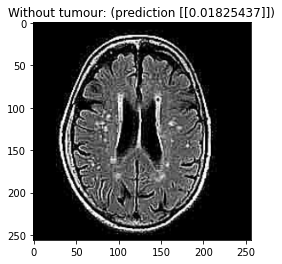

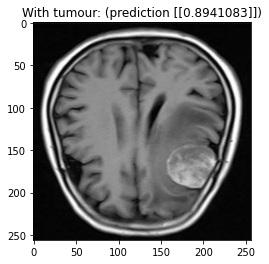

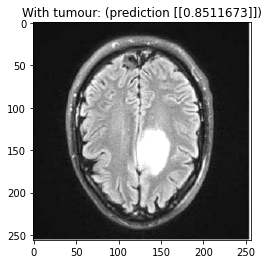

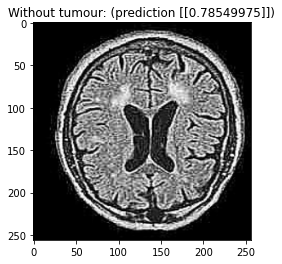

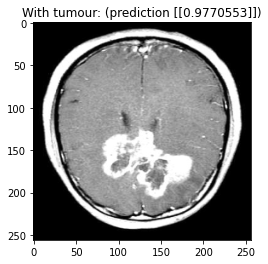

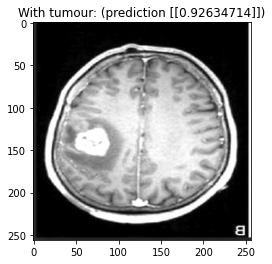

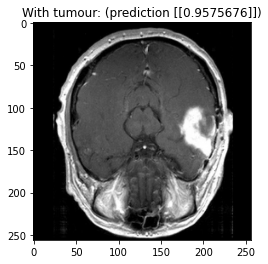

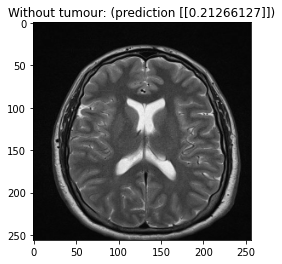

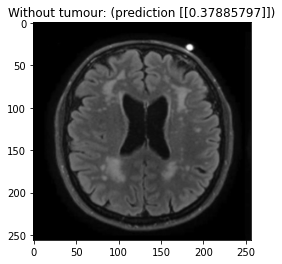

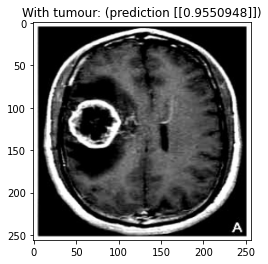

In [49]:
TestModel()